# Convolutional Neural Network

The following notebook is an example found on the pytorch website:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

It uses data imported from torchvision and runs a CNN on the image data to classify it.

Gif from: https://giphy.com/gifs/blog-daniel-keypoints-i4NjAwytgIRDW

CNN architecture image and good introduction to CNNs: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

### CNN Architecture

An input image is passed through alternativ convolutional and pooling layers where each convolutional layer shrinks the data dimensions. The data is then flattened into 1D and a Fully Connected Network (FCN) is appended to the CNN to classify the image. The Convolutional layers are feature extractors that are then used in the FCN.

![title](../images/CNN.jpeg)

### How a Convolution works

A kernel (Yellow Box) starts in the upper-left corner with values in red. The dot product of the kernel and the overlapping "image" is computed to get the filled in numbers in the red matrix on the right. The kernel will shift over and repeat until the red matrix is filled in. Note how the output is smaller than the original matrix.

<img src="../images/giphy.gif" width="750" align="center">

### Running a CNN: Import data

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Display One Batch of 4 Images

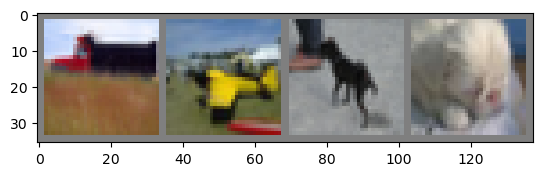

truck plane dog   dog  


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Create the actual CNN

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Define Cost Function and Optimization Method

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the Network on the Data

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.849
[1,  6000] loss: 1.652
[1,  8000] loss: 1.553
[1, 10000] loss: 1.497
[1, 12000] loss: 1.455
[2,  2000] loss: 1.397
[2,  4000] loss: 1.360
[2,  6000] loss: 1.348
[2,  8000] loss: 1.306
[2, 10000] loss: 1.288
[2, 12000] loss: 1.267
Finished Training


### Save the Network

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Load in a test batch

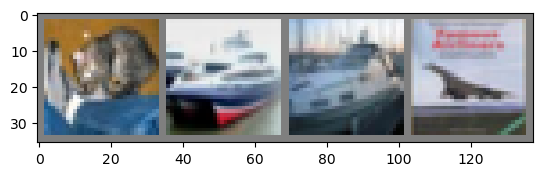

GroundTruth:  cat   ship  ship  plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Load the trained CNN and input the test images

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

/tmp/ipykernel_3709578/238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [18]:
outputs = net(images)

### Print the predictions the CNN made

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


### Find the accuracy of the Model on the entire dataset

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


### Find the accuracy of the model for each picture type

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 54.1 %
Accuracy for class car   is: 79.4 %
Accuracy for class bird  is: 20.0 %
Accuracy for class cat   is: 61.0 %
Accuracy for class deer  is: 59.1 %
Accuracy for class dog   is: 25.2 %
Accuracy for class frog  is: 61.0 %
Accuracy for class horse is: 57.0 %
Accuracy for class ship  is: 63.4 %
Accuracy for class truck is: 49.1 %
